## How we can use bootstrap?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install arch
from arch.bootstrap import IIDBootstrap, IndependentSamplesBootstrap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 11.6 MB/s eta 0:00:00


This project consists of two parts

1. Writing bootstrap from scratch and obtaining the Laplace distribution parameters

2. Applying bootstrap to real data to construct confidence interval of the mean

## Part 1


## Data:

Firstly let's create Laplace distribution sample with parameters $\mu = 5$ и $b = 3$:

$$
f(x|\mu, b) = \frac{1}{2b}\exp(-\frac{|x - \mu|}{b})
$$

In [ ]:
sample = np.random.laplace(loc=5, scale=3, size=100)

## Bootstrap

Let's sample n subsamples with a return from our sample and estimate $\hat{\mu}$ each of the subsamples using MLE estimation, which for [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution):

$$
\hat{\mu_i} = \mathrm{median}(x_i)
$$

$x_i \in$  $i-$ subsample, and final $\mu$ of our initial sample we can estimate as the mean of n-subsamples:

$$
\mu = \frac{1}{n}\sum_{i=1}^{n} \hat{\mu_i}
$$


We can do the same thing for $\hat{b}$:
$$
\hat{b_i} = \frac{1}{k} \sum_{i = 1}^{k} |x_i - \hat{\mu}^k|
$$
k - size of subsample. $\hat{\mu}^k$ - it's median.

Estimation of $b$ we can find as:

$$
b = \frac{1}{n}\sum_{i=1}^{n} \hat{b_i}
$$

In [ ]:
class Bootstrap_Laplace:

    def __init__(self, sample, n):

        self.sample = sample
        self.n = n

    def sampling(self):
        #_sub_samples generation
        samples = [np.random.choice(self.sample, 100, replace=True) for i in range(self.n)]

        return samples

    def loc_scale_observing(self):
        #parameters estimation
        samples = self.sampling()
        means = [np.median(samples[i]) for i in range(len(samples))]
        scales = [(1/len(samples[0]))*sum([abs(x - means[i]) for x in samples[i]]) for i in range(len(samples))]

        return np.mean(means), np.mean(scales)

In [ ]:
booststrap = Bootstrap_Laplace(sample, 1000)

In [ ]:
mu, b = booststrap.loc_scale_observing()
print(f'for our distribution we have: 𝜇 = {mu} and b = {b}')

for our distribution we have: 𝜇 = 4.854881482582119 and b = 3.004308480180321


We can see that our estimation $\mu$ is truly: $$\mu_{real} = 5 \text{ versus } \mu_{estimated} \approx 4.86$$

We can say the same thing of $b$: $$b_{real} = 3 \text{ versus } b_{estimated} \approx 3.01$$

## Part 2

## Data:

I use [go to college dataset](https://www.kaggle.com/datasets/saddamazyazy/go-to-college-dataset) from kaggle :)

<img src=https://wp.dailybruin.com/images/2019/08/gap-years--910x1024.png width="500" height="500">

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('data.csv')
data.head()

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,will_go_to_college
0,Academic,A,Male,Less Interested,Urban,56,6950000,83.0,84.09,False,True
1,Academic,A,Male,Less Interested,Urban,57,4410000,76.8,86.91,False,True
2,Academic,B,Female,Very Interested,Urban,50,6500000,80.6,87.43,False,True
3,Vocational,B,Male,Very Interested,Rural,49,6600000,78.2,82.12,True,True
4,Academic,A,Female,Very Interested,Urban,57,5250000,75.1,86.79,False,False


We are interesting if the person will go to college or not. We can imagine that his grades can influence this. Let's explore!  

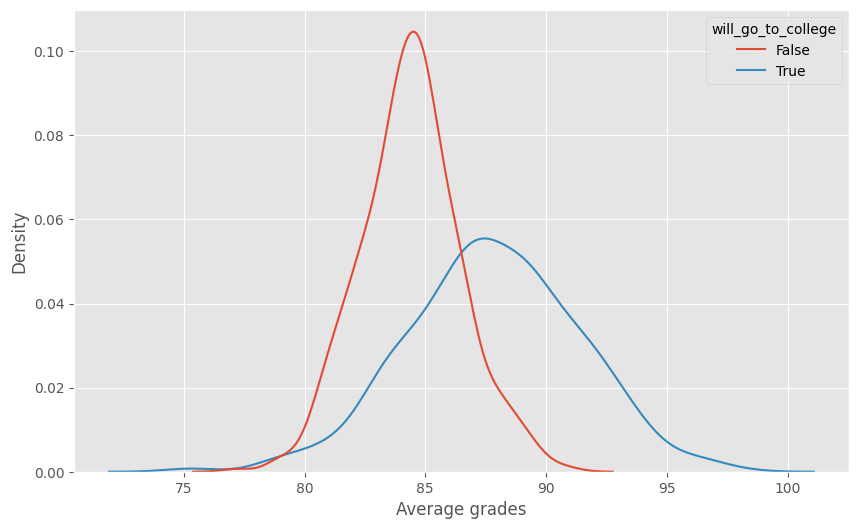

In [ ]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
fig = sns.kdeplot(data=data, x='average_grades', hue='will_go_to_college', label = 'Go to college')
fig.set(xlabel='Average grades', ylabel='Density')
plt.show()

As expected college eplicant's graph is shifted to the right. Their average grades are higher. We can estimate each group the mean range of grades by constructing confidence intervals using bootstrap.

In [ ]:
#let's devide students into two groups: applicants (students) and not (gaps), each consists of their average grades

students = data[data['will_go_to_college'] == True]['average_grades']
gaps = data[data['will_go_to_college'] == False]['average_grades']

In [ ]:
#Final interval estimate of the average

bs_students = IIDBootstrap(students, seed=111111)
bs_gapes = IIDBootstrap(gaps, seed=111111)
conf_ont_students = bs_students.conf_int(np.mean, method='percentile', reps=10000, size=0.95)
conf_ont_gaps = bs_gapes.conf_int(np.mean, method='percentile', reps=10000, size=0.95)

print(f'conf interval for average students score: from {conf_ont_students[0][0]} to {conf_ont_students[1][0]}')
print(f'conf interval for average gaps score: from {conf_ont_gaps[0][0]} to {conf_ont_gaps[1][0]}')

conf interval for average students score: from 87.4914045 to 88.11904950000002
conf interval for average gaps score: from 84.2109955 to 84.57082000000001


As a result we can conclude that with 95% probability the average grade of future students is in range  $\in (87.5, 88.1)$

For gaps students: $\in (84.2, 84.6)$

Which is quite logical, the score of applicants is higher :)